# Validation of distances between related Embeddings

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm

from networks.resnet_big import SupCEResNet, SupConResNet, model_dict
from util_diff import DiffLoader, DiffTransform
from util_diff import SameTwoRandomResizedCrop, SameTwoColorJitter, SameTwoApply

seaborn.set_theme(style="darkgrid")

### Parameters

In [48]:
cuda_device = 0
tsenecuda_venv = "/home/tgottwald/tsnecuda_venv/"

# root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"
root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_colorAug_cosine/models/ckpt_epoch_200.pth"
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupCon_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/ckpt_epoch_200.pth"

dataset_1 = "animals10_diff_-1"
dataset_2 = "animals10_diff_4000"

aug_dict = {'aug': ['colorJitter', 'grayscale'], 'resizedCrop': [0.5, 1.0, 3/4, 4/3], 'horizontalFlip': 0.5, 'colorJitter': [0.8, 0.4, 0.4, 0.4, 0.4], 'grayscale': 0.2}

In [49]:
def get_root_dataset_test(dataset):
    if dataset == "animals10" or dataset == "animals10_300x300":
        # animals10_300x300
        root_train = "./datasets/animals10_300x300/train/"
        root_test = "./datasets/animals10_300x300/test/"
    elif dataset == "animals10_diff_-1":
        root_train = "./datasets/animals10_diff/-1/train/"
        root_test = "./datasets/animals10_diff/-1/test/"
    elif dataset == "animals10_diff_4000":
        root_train = "./datasets/animals10_diff/4000/train/"
        root_test = "./datasets/animals10_diff/4000/test/"
    else:
        root_test = None

    return root_train, root_test

def get_paths_to_embeddings_and_run_md(root_model, dataset_1, dataset_2):
    split_model = root_model.split('/')

    epoch = split_model[-1].replace(".pth", '').split('_')[-1]

    training_dataset = split_model[-4]

    path_run_md = os.path.join(*split_model[:-2], "run.md")
    path_embeddings_1 = os.path.join(*split_model[:-2], (f"val_{epoch}" if dataset_1 == training_dataset else f"val_{dataset_1}_{epoch}"), "embeddings")
    path_embeddings_2 = os.path.join(*split_model[:-2], (f"val_{epoch}" if dataset_2 == training_dataset else f"val_{dataset_2}_{epoch}"), "embeddings")

    if dataset_1 < dataset_2:
        path_comb = os.path.join(*split_model[:-2], f"comb_{dataset_1}_{dataset_2}")
    else:
        path_comb = os.path.join(*split_model[:-2], f"comb_{dataset_2}_{dataset_1}")

    return path_run_md, path_comb, path_embeddings_1, path_embeddings_2, epoch

def try_eval(val):
    try:
        return eval(val)
    except:
        return val
    
def read_parameters_from_run_md(path_run_md):
    with open(path_run_md, 'r') as f:
        lines = f.readlines()

    params = dict()

    line_indices = [7, 13, 19]
    for idx in line_indices:
        params_names = lines[idx].split(' | ')
        params_names[0] = params_names[0].replace('| ', '')
        params_names[-1] = params_names[-1].replace(' |\n', '')
        params_names = [name.replace(' ', '_') for name in params_names]

        params_vals = lines[idx+2].split('|')[1:-1]
        params_vals = [try_eval(val) for val in params_vals]

        for i,n in enumerate(params_names):
            params[n] = params_vals[i]

    return params

In [50]:
_, root_test_1 = get_root_dataset_test(dataset_1)
_, root_test_2 = get_root_dataset_test(dataset_2)

path_run_md, path_comb, path_embeddings_1, path_embeddings_2, epoch = get_paths_to_embeddings_and_run_md(root_model, dataset_1, dataset_2)

params = read_parameters_from_run_md(path_run_md)

### Model and DataLoaders

In [51]:
def set_aug_transform(params, aug=['resizedCrop', 'horizontalFlip', 'colorJitter', 'grayscale'],
                      resizedCrop=[0.2, 1.0, 3/4, 4/3], horizontalFlip=0.5, colorJitter=[0.8, 0.4, 0.4, 0.4, 0.4], grayscale=0.2):
    normalize = transforms.Normalize(mean=params['mean'], std=params['std'])

    same_transform_list = []
    same_transform_list = []
    if 'sameResizedCrop' in aug:
        scaleMin, scaleMax, ratioMin, ratioMax = resizedCrop
        same_transform_list.append(SameTwoRandomResizedCrop(size=300, scale=(scaleMin, scaleMax), ratio=(ratioMin, ratioMax)))
    if 'sameHorizontalFlip' in aug:
        same_transform_list.append(transforms.RandomApply([
            SameTwoApply(transforms.RandomHorizontalFlip(p=1.0))
        ], p=horizontalFlip))
    if 'sameColorJitter' in aug:
        pJitter, brightness, contrast, saturation, hue = colorJitter
        same_transform_list.append(transforms.RandomApply([
            SameTwoColorJitter(brightness, contrast, saturation, hue)
        ], p=pJitter))
    if 'sameGrayscale' in aug:
        same_transform_list.append(transforms.RandomApply([
            SameTwoApply(transforms.RandomGrayscale(p=1.0))
        ], p=grayscale))

    transform_list = []
    if 'resizedCrop' in aug:
        scaleMin, scaleMax, ratioMin, ratioMax = resizedCrop
        transform_list.append(transforms.RandomResizedCrop(size=300, scale=(scaleMin, scaleMax), ratio=(ratioMin, ratioMax)))
    if 'horizontalFlip' in aug:
        transform_list.append(transforms.RandomHorizontalFlip(p=horizontalFlip))
    if 'colorJitter' in aug:
        pJitter, brightness, contrast, saturation, hue = colorJitter
        transform_list.append(transforms.RandomApply([
            transforms.ColorJitter(brightness, contrast, saturation, hue)
        ], p=pJitter))
    if 'grayscale' in aug:
        transform_list.append(transforms.RandomGrayscale(p=grayscale))
    transform_list.extend([
        transforms.ToTensor(),
        normalize
    ])

    if len(same_transform_list) > 0:
        aug_same_transform = transforms.Compose(same_transform_list)
    else:
        aug_same_transform = None

    aug_transform = transforms.Compose(transform_list)

    return DiffTransform(aug_transform, aug_same_transform)

In [52]:
if len(aug_dict['aug']) > 0:
    # load model checkpoint
    model = SupConResNet(name=params['model'])

    ckpt = torch.load(root_model, map_location='cpu')
    state_dict = ckpt['model']

    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    state_dict = new_state_dict

    model = model.cuda(device=cuda_device)

    model.load_state_dict(state_dict)

    # set dataloader
    aug_transform = set_aug_transform(params=params, **aug_dict)

    aug_val_dataset = datasets.ImageFolder(root=root_test_1,
                                           loader=DiffLoader(path_orig=root_test_1, path_diff=root_test_2),
                                           transform=aug_transform)
    aug_val_loader = torch.utils.data.DataLoader(aug_val_dataset, batch_size=params['batch_size'], shuffle=False,
                                                 num_workers=8, pin_memory=True)

### Embeddings

In [53]:
with open(os.path.join(path_embeddings_1, "embedding_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_1 = entry['data']
    class_labels = entry['labels']

with open(os.path.join(path_embeddings_2, "embedding_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_2 = entry['data']

if len(aug_dict['aug']) == 0:
    with open(os.path.join(path_embeddings_1, "embedding_train"), 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        embedding_train_1 = entry['data']
        class_labels_train = entry['labels']

    with open(os.path.join(path_embeddings_2, "embedding_train"), 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        embedding_train_2 = entry['data']
else:
    _, embedding_size = model_dict[params['model']]

    model.eval()

    embedding_aug_1 = np.array([])
    embedding_aug_2 = np.array([])
    class_labels = np.array([], dtype=int)
    for idx, (images, labels) in enumerate(tqdm(aug_val_loader)):
        # embedding 1
        images_1 = images[0].cuda(device=cuda_device, non_blocking=True)

        with torch.no_grad():
            features_1 = model.encoder(images_1)

        embedding_aug_1 = np.append(embedding_aug_1, features_1.cpu().numpy())
        class_labels = np.append(class_labels, labels.numpy())

        # embedding 2
        images_2 = images[1].cuda(device=cuda_device, non_blocking=True)

        with torch.no_grad():
            features_2 = model.encoder(images_2)

        embedding_aug_2 = np.append(embedding_aug_2, features_2.cpu().numpy())

    embedding_aug_1 = embedding_aug_1.reshape(-1, embedding_size)
    embedding_aug_2 = embedding_aug_2.reshape(-1, embedding_size)

100%|██████████| 202/202 [01:59<00:00,  1.69it/s]


### Investigate Distances

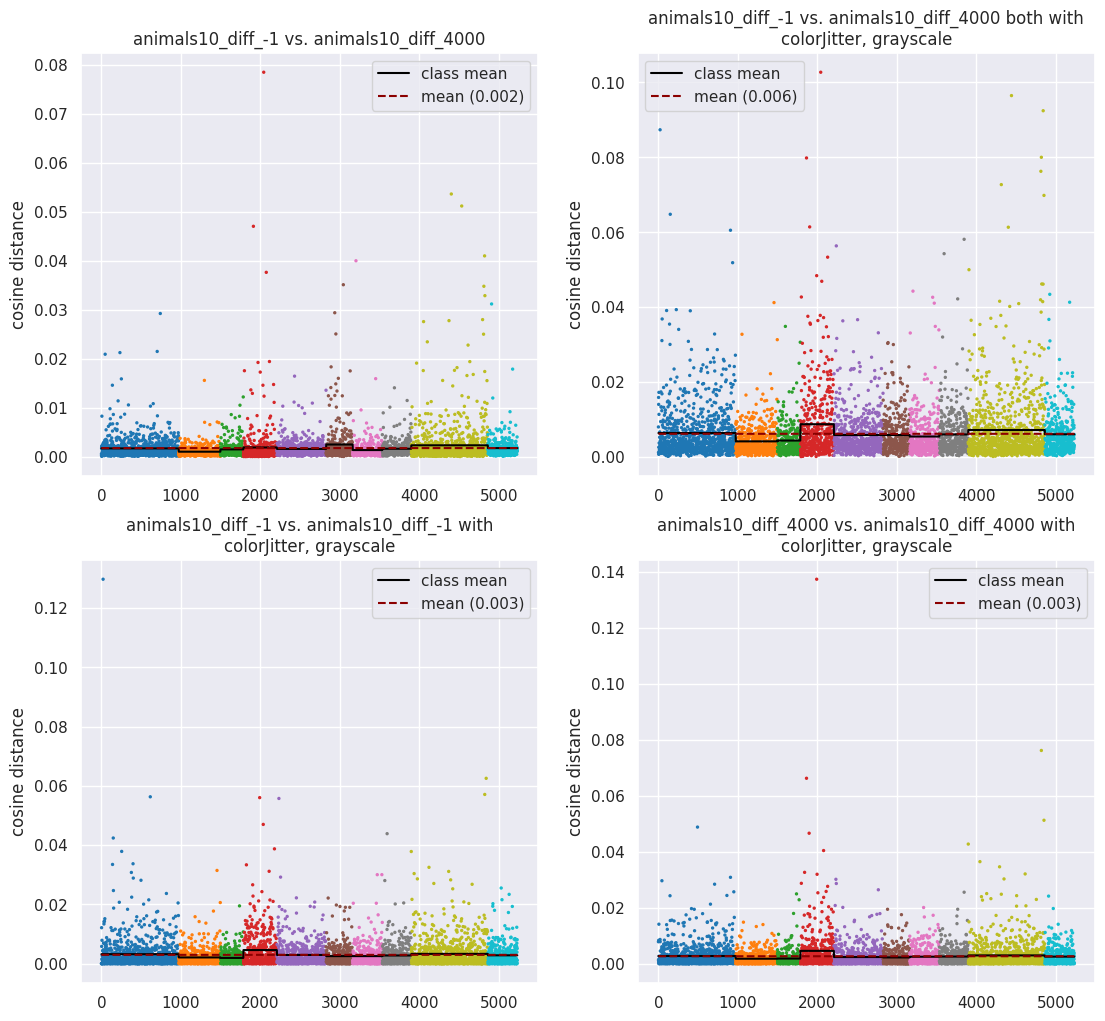

In [54]:
if len(aug_dict['aug']) == 0:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
    fig.tight_layout(w_pad=3)

    distances_embeddings = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_1), torch.tensor(embedding_2))
    distances_embeddings[distances_embeddings < 1e-8] = 0.0
    df = pd.DataFrame.from_dict({'dist': distances_embeddings, 'label': class_labels})
    df['mean'] = len(df)*[df['dist'].mean()]
    df['class_mean'] = df.groupby('label').mean()['dist'].repeat(df.groupby('label').count().values[:,0]).values
    df['index'] = df.index
    distances_embeddings_train = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_train_1), torch.tensor(embedding_train_2))
    distances_embeddings_train[distances_embeddings_train < 1e-8] = 0.0
    df_train = pd.DataFrame.from_dict({'dist': distances_embeddings_train, 'label': class_labels_train})
    df_train['mean'] = len(df_train)*[df_train['dist'].mean()]
    df_train['class_mean'] = df_train.groupby('label').mean()['dist'].repeat(df_train.groupby('label').count().values[:,0]).values
    df_train['index'] = df_train.index

    axs[0].scatter(np.arange(len(class_labels_train)), distances_embeddings_train, s=2, c=class_labels_train, cmap='tab10')
    df_train['class_mean'].plot(c='black', label="class mean", ax=axs[0])
    df_train['mean'].plot(c='darkred', linestyle='--', label=f"mean ({df_train['mean'][0]:.3f})", ax=axs[0])
    axs[0].set_ylabel('cosine distance')
    axs[0].legend()
    axs[0].set_title(f"Training Data:\n{dataset_1} vs. {dataset_2}")

    axs[1].scatter(np.arange(len(class_labels)), distances_embeddings, s=2, c=class_labels, cmap='tab10')
    df['class_mean'].plot(c='black', label="class mean", ax=axs[1])
    df['mean'].plot(c='darkred', linestyle='--', label=f"mean ({df['mean'][0]:.3f})", ax=axs[1])
    axs[1].set_ylabel('cosine distance')
    axs[1].legend()
    axs[1].set_title(f"Test Data:\n{dataset_1} vs. {dataset_2}")
else:
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(11,10))
    fig.tight_layout(h_pad=3, w_pad=3)

    distances_embeddings = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_1), torch.tensor(embedding_2))
    distances_embeddings[distances_embeddings < 1e-8] = 0.0
    distances_embeddings_aug = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_aug_1), torch.tensor(embedding_aug_2))
    distances_embeddings_aug[distances_embeddings_aug < 1e-8] = 0.0
    distances_embeddings_aug_1 = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_1), torch.tensor(embedding_aug_1))
    distances_embeddings_aug_1[distances_embeddings_aug_1 < 1e-8] = 0.0
    distances_embeddings_aug_2 = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_2), torch.tensor(embedding_aug_2))
    distances_embeddings_aug_2[distances_embeddings_aug_2 < 1e-8] = 0.0
    df = pd.DataFrame.from_dict({'dist': distances_embeddings, 'dist_aug': distances_embeddings_aug, 'dist_aug_1': distances_embeddings_aug_1,
                             'dist_aug_2': distances_embeddings_aug_2, 'label': class_labels})
    df = df.join(pd.DataFrame(
        np.repeat(df.groupby('label').mean().values, repeats=df.groupby('label').count().values[:,0], axis=0)
    ).rename(columns={0: 'class_mean', 1: 'class_mean_aug', 2: 'class_mean_aug_1', 3: 'class_mean_aug_2'}))
    df['mean'] = len(df)*[df['dist'].mean()]
    df['mean_aug'] = len(df)*[df['dist_aug'].mean()]
    df['mean_aug_1'] = len(df)*[df['dist_aug_1'].mean()]
    df['mean_aug_2'] = len(df)*[df['dist_aug_2'].mean()]

    axs[0,0].scatter(np.arange(len(class_labels)), distances_embeddings, s=2, c=class_labels, cmap='tab10')
    df['class_mean'].plot(c='black', label="class mean", ax=axs[0,0])
    df['mean'].plot(c='darkred', linestyle='--', label=f"mean ({df['mean'][0]:.3f})", ax=axs[0,0])
    axs[0,0].set_ylabel('cosine distance')
    axs[0,0].set_title(f"{dataset_1} vs. {dataset_2}")
    axs[0,0].legend()

    axs[0,1].scatter(np.arange(len(class_labels)), distances_embeddings_aug, s=2, c=class_labels, cmap='tab10')
    df['class_mean_aug'].plot(c='black', label="class mean", ax=axs[0,1])
    df['mean_aug'].plot(c='darkred', linestyle='--', label=f"mean ({df['mean_aug'][0]:.3f})", ax=axs[0,1])
    axs[0,1].set_ylabel('cosine distance')
    axs[0,1].set_title(f"{dataset_1} vs. {dataset_2} both with\n{', '.join(aug_dict['aug'])}")
    axs[0,1].legend()

    axs[1,0].scatter(np.arange(len(class_labels)), distances_embeddings_aug_1, s=2, c=class_labels, cmap='tab10')
    df['class_mean_aug_1'].plot(c='black', label="class mean", ax=axs[1,0])
    df['mean_aug_1'].plot(c='darkred', linestyle='--', label=f"mean ({df['mean_aug_1'][0]:.3f})", ax=axs[1,0])
    axs[1,0].set_ylabel('cosine distance')
    axs[1,0].set_title(f"{dataset_1} vs. {dataset_1} with\n{', '.join(aug_dict['aug'])}")
    axs[1,0].legend()

    axs[1,1].scatter(np.arange(len(class_labels)), distances_embeddings_aug_2, s=2, c=class_labels, cmap='tab10')
    df['class_mean_aug_2'].plot(c='black', label="class mean", ax=axs[1,1])
    df['mean_aug_2'].plot(c='darkred', linestyle='--', label=f"mean ({df['mean_aug_2'][0]:.3f})", ax=axs[1,1])
    axs[1,1].set_ylabel('cosine distance')
    axs[1,1].set_title(f"{dataset_2} vs. {dataset_2} with\n{', '.join(aug_dict['aug'])}")
    axs[1,1].legend()

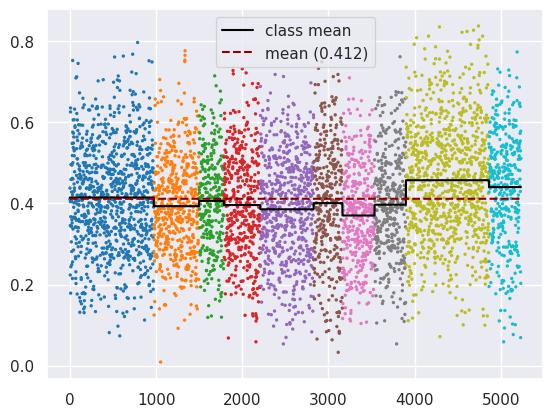

In [57]:
distances_embeddings_roll = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_1), torch.tensor(embedding_2).roll(1, dims=0))
df_roll = pd.DataFrame.from_dict({'dist': distances_embeddings_roll, 'label': class_labels})
df_roll['mean'] = len(df_roll)*[df_roll['dist'].mean()]
df_roll['class_mean'] = df_roll.groupby('label').mean()['dist'].repeat(df_roll.groupby('label').count().values[:,0]).values
df_roll['index'] = df_roll.index

plt.scatter(np.arange(len(class_labels)), distances_embeddings_roll, s=2, c=class_labels, cmap='tab10')
df_roll['class_mean'].plot(c='black', label="class mean")
df_roll['mean'].plot(c='darkred', linestyle='--', label=f"mean ({df_roll['mean'][0]:.3f})")
plt.legend()

### t-SNE of two Datasets

In [13]:
path_tsne_save = os.path.join(path_comb, f"{epoch}")

sample_size = 10

tsenecuda_venv_lib64 = os.path.join(tsenecuda_venv, "lib64")
tsenecuda_venv_interpreter = os.path.join(tsenecuda_venv, "bin/python")

In [22]:
!CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings_1} --path_second {path_embeddings_2} --path_save {path_tsne_save}

Data split train
load feature embedding
load second feature embedding
compute t-SNE embedding
writ t-SNE embedding
Data split test
load feature embedding
load second feature embedding
compute t-SNE embedding
writ t-SNE embedding


In [23]:
with open(os.path.join(path_tsne_save, "embedding_tSNE_train"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_train = entry['data']
    labels_train = entry['labels']
N_train = len(labels_train)//2
num_classes = len(set(labels_train))
df_train = pd.DataFrame.from_dict({'x': embedding_tSNE_train[:,0], 'y': embedding_tSNE_train[:,1], 'label': labels_train,
                                   'dataset': N_train*[dataset_1]+N_train*[dataset_2], 'dataset_label': N_train*[0]+N_train*[1]})

with open(os.path.join(path_tsne_save, "embedding_tSNE_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_test = entry['data']
    labels_test = entry['labels']
N_test = len(labels_test)//2
df_test = pd.DataFrame.from_dict({'x': embedding_tSNE_test[:,0], 'y': embedding_tSNE_test[:,1], 'label': labels_test,
                                   'dataset': N_test*[dataset_1]+N_test*[dataset_2], 'dataset_label': N_test*[0]+N_test*[1]})

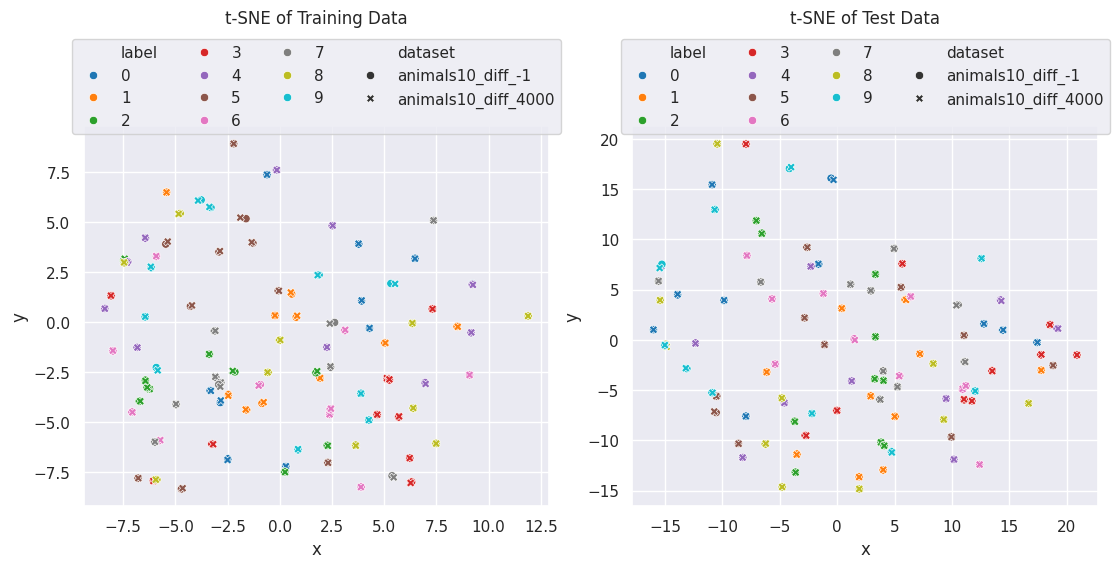

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))
fig.tight_layout(w_pad=2)

df_train_sample = df_train[df_train.dataset_label == 0].groupby('label').sample(sample_size)
indices_train = np.array([[idx, idx+N_train] for idx in df_train_sample.index]).reshape(-1)
seaborn.scatterplot(data=df_train.loc[indices_train], x='x', y='y', hue='label', style='dataset', palette='tab10', ax=axs[0])
axs[0].set_title("t-SNE of Training Data", y=1.25)
axs[0].legend(loc="upper center", ncols=4, bbox_to_anchor=(0.5,1.25))

df_test_sample = df_test[df_test.dataset_label == 0].groupby('label').sample(sample_size)
indices_test = np.array([[idx, idx+N_test] for idx in df_test_sample.index]).reshape(-1)
seaborn.scatterplot(data=df_test.loc[indices_test], x='x', y='y', hue='label', style='dataset', palette='tab10', ax=axs[1])
axs[1].set_title("t-SNE of Test Data", y=1.25)
axs[1].legend(loc="upper center", ncols=4, bbox_to_anchor=(0.5,1.25))